# Effects of Class Imbalance
## CSC2034
### Cameron Trotter (c.trotter2@ncl.ac.uk)


In previous notebooks, we have worked with balanced synthetic data. In reaality, the data you work with will often be imbalanced, with some classes containing more examples than others. In this practical, we will examine the effect that class imbalance can have on the performance of models you create. 

### Google Colab Setup

All of the notebooks you will be running in these lab sessions are designed to be ran using [Google Colab](https://colab.research.google.com/). For setup instructions, see this repo's README. 

In order to make things work on colab, we need to clone this repo and then (in another cell because colab dictates this...) move into the repo directory.


In [1]:
!git clone https://github.com/Trotts/csc2034-ds-demos.git

Cloning into 'csc2034-ds-demos'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 127 (delta 49), reused 107 (delta 32), pack-reused 0
Receiving objects: 100% (127/127), 3.66 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
import os
os.chdir('csc2034-ds-demos')

### Generate an unbalanced dataset

Whilst we can use `sklearn` to create datasets, these will be balanced. Here we want a dsynthetic dataset that is unbalanced. To achieve this, we can manually flip a set percentage of data point classes. First, lets recap making a dataset. 

Task: Using the notebooks previously create a balanced, linearly sparable dataset. I have provided hyperparameters for you. 

In [3]:
from sklearn.datasets import make_classification


n_samples = 1000
n_classes = 2
n_features = 2
n_clusters_per_class = 2
n_redundant = 0
n_informative = 2
random_state = 5
flip_y = 0.1

data, labels = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=n_classes,
    n_clusters_per_class=n_clusters_per_class,
    random_state=random_state,
    flip_y=flip_y,
)

Now that we have a dataset, lets see how many examples of each class we have. 

Number of class 0 examples: 511
Number of class 1 examples: 489


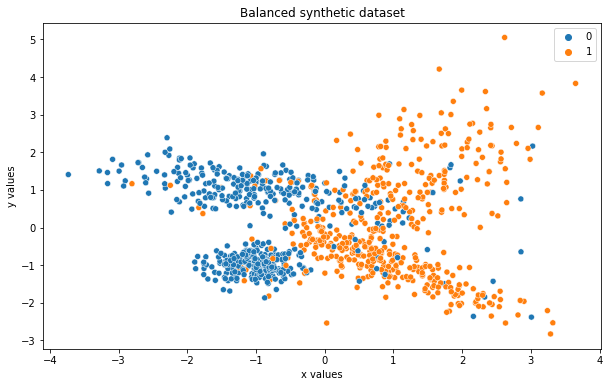

In [4]:
import numpy as np
from helpers import show_scatterplot

unique, counts = np.unique(labels, return_counts=True)
print(f"Number of class 0 examples: {counts[0]}")
print(f"Number of class 1 examples: {counts[1]}")

show_scatterplot(data, labels, "Balanced synthetic dataset")

Run the below checks. If any return False, take another look at the code you have written before continuing. 

In [5]:
print(f"Class balance check, number of class 0 examples: {counts[0] == 511}")
print(f"Class balance check, number of class 1 examples: {counts[1] == 489}")

Class balance check, number of class 0 examples: True
Class balance check, number of class 1 examples: True


As you can see, our data is mostly balanced. There are only 22 more examples of class 0 than class 1. To really create a class imbalance, I have produced some code (found in `helpers.py`) which will skew this further.

421 labels values flipped
class labels ratio: 0.10
Number of class 0 examples: 90
Number of class 1 examples: 910


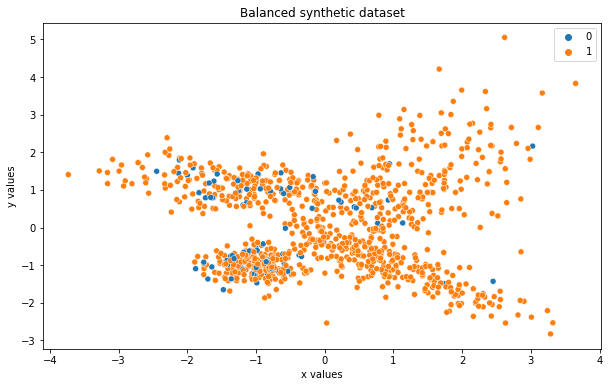

In [6]:
from helpers import create_imbalance

percentage_imbalance = 0.9
imbalanced_labels = create_imbalance(labels, percentage_imbalance)

unique, counts = np.unique(imbalanced_labels, return_counts=True)
print(f"Number of class 0 examples: {counts[0]}")
print(f"Number of class 1 examples: {counts[1]}")

show_scatterplot(data, imbalanced_labels, "Balanced synthetic dataset")

### Dealing with class imbalance


Now our dataset is heavily skewed towards class 1 examples, lets take a look at the different ways we can deal with this. 

#### Approach 1: Downsampling

Downsampling is one method for dealing with imbalanced data. With this approach, the majority class is reduced to closely match the minority class by simply removing examples of the majority class from the dataset. Code to achieve this is provided in `helpers.py`. Spend some time reading and understanding this code.

For all types of augmentation, it is important we only perform this on the training set. The test set should be left as is to ensure our classifier's evaluation metrics are not biased by any changes made to the test set. 

current class labels ratio: 0.11
501 majority class records removed 
new class labels ratio: 0.64
counts:  Counter({1: 103, 0: 66})


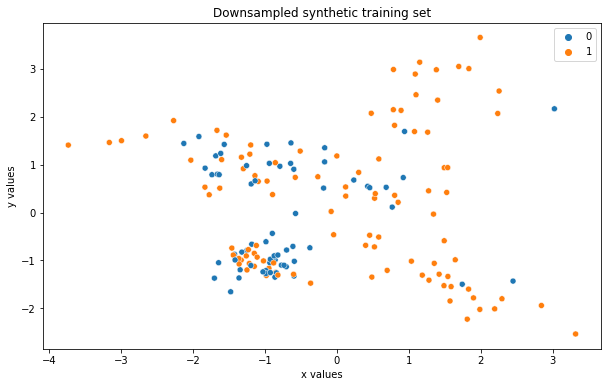

In [7]:
from helpers import downsample
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(data,
                                                                    imbalanced_labels,
                                                                    test_size = 0.33,
                                                                    random_state = 5)


downsampled_data, downsampled_labels = downsample(data_train, labels_train)

show_scatterplot(downsampled_data, downsampled_labels, "Downsampled synthetic training set")

On the plus side, we now have a more balanced dataset. On the downside, we now have far less data to train a model on.

#### Approach 2: SMOTE

In some cases, such as the one above, we may not want to downsample our dataset as this would leave us with too few data points to train a model on. What if we could do the opposite - that is, oversample the data to create more datapoints?

SMOTE, or Synthetic Minority Over-Sampling Technique, allows you to do just that! Proposed by Chawla *et al.* in 2002, the method generates fake data for the minority class which mirrors the qualities of the real data. This can be very powerful!

If you want to learn more about SMOTE, you can read the paper [here](https://www.jair.org/index.php/jair/article/view/10302). SMOTE itself has been implemented as part of the [imbalanced-learn](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html?highlight=smote#imblearn.over_sampling.SMOTE) python package. 

Task: Using the package documentation linked above, utilise SMOTE to oversample the imbalanced training data we created. Ensure the `random_state` below is used. It is fine to use default parameters for all other arguments. 

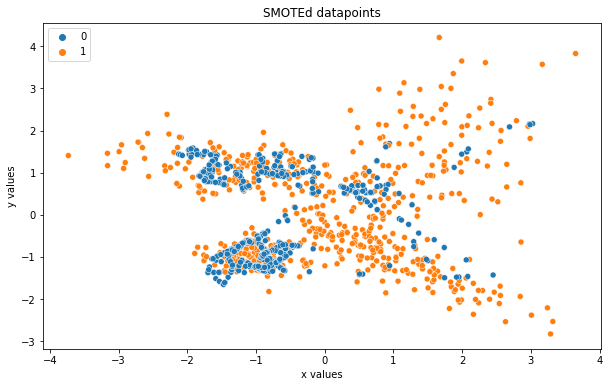

In [8]:
from imblearn.over_sampling import SMOTE

random_state = 5

smote = SMOTE(random_state=random_state)
smote_train_data, smote_train_labels = smote.fit_resample(data_train, labels_train)

show_scatterplot(smote_train_data, smote_train_labels, "SMOTEd datapoints")

SMOTE will attempt to create an equal number of examples for each class. Let's see if that has happened...

In [17]:
unique, counts = np.unique(smote_train_labels, return_counts=True)

print(f"After SMOTE, number of class 0 examples: {counts[0]}")
print(f"After SMOTE, number of class 1 examples: {counts[1]}")


After SMOTE, number of class 0 examples: 604
After SMOTE, number of class 1 examples: 604


Run the below checks. If any return False, take another look at the code you have written before continuing. 

In [10]:
print(f"SMOTE check, number of class 0 examples: {counts[0] == 599}")
print(f"SMOTE check, number of class 1 examples: {counts[1] == 599}")

SMOTE check, number of class 0 examples: False
SMOTE check, number of class 1 examples: False


Let's plot the distribution of data we have after SMOTE.

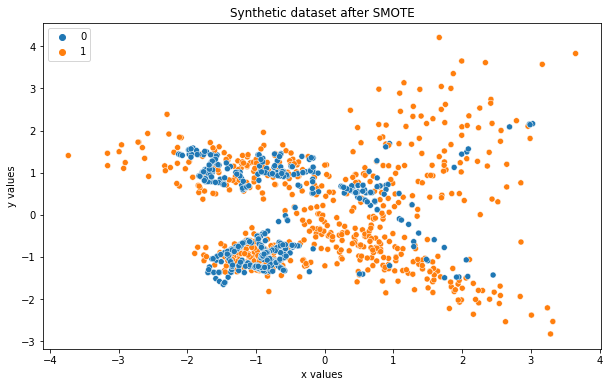

In [11]:
show_scatterplot(smote_train_data, smote_train_labels, "Synthetic dataset after SMOTE")

As you can see, SMOTE has utilised the existing datapoints for the minority class and has used them to create synthetic data that closely mimics them. We can then use data created using SMOTE in the same way as before to train models. 

Task: Using a model of your choice, train a model on the SMOTE data and generate evaluation metrics. 

Test acc: 58.78787878787879%


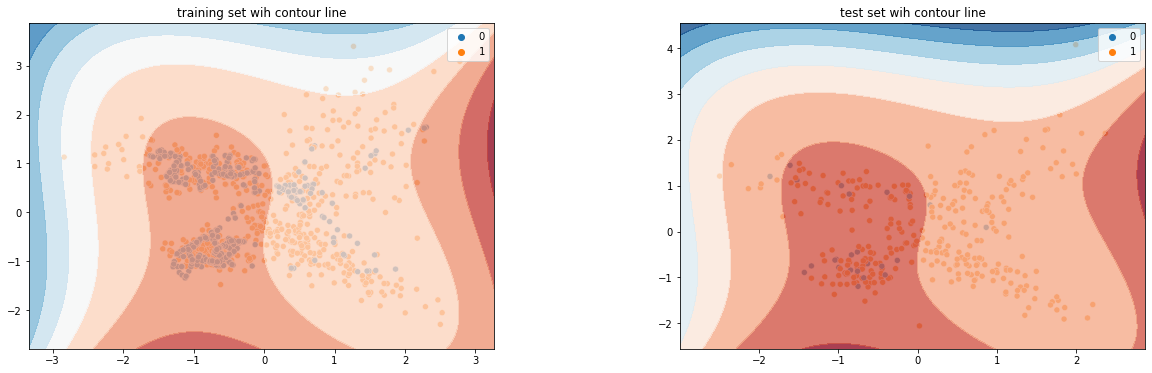

In [12]:
#...
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)

smote_train_data_scaled = scaler.transform(smote_train_data)
smote_test_data_scaled = scaler.transform(data_test)


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from helpers import plot_contour_fit

kernel = 'poly'
degree = 3
C = 5
coef0 = 1

non_linear_svm = SVC(
    kernel=kernel,
    degree=degree,
    C=C,
    coef0=coef0,
)
non_linear_svm.fit(smote_train_data_scaled, smote_train_labels)

non_linear_svm_label_predictions = non_linear_svm.predict(smote_test_data_scaled)
test_acc = accuracy_score(labels_test, non_linear_svm_label_predictions)

print(f"Test acc: {test_acc * 100}%")
plot_contour_fit(non_linear_svm, smote_train_data_scaled, smote_train_labels,
                 smote_test_data_scaled, labels_test)

Test acc: 72.42424242424242%


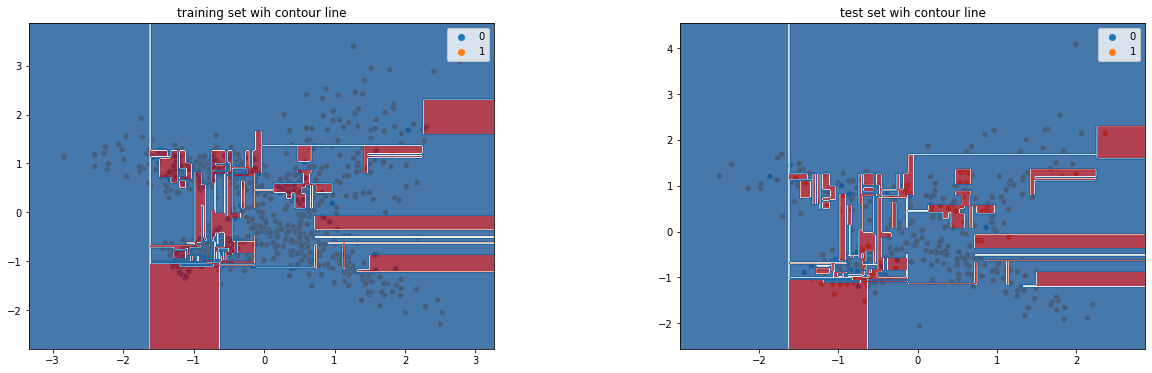

In [20]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(smote_train_data_scaled, smote_train_labels)

decision_tree_predictions = decision_tree.predict(smote_test_data_scaled)

test_acc = accuracy_score(labels_test, decision_tree_predictions)

print(f"Test acc: {test_acc * 100}%")

plot_contour_fit(decision_tree, smote_train_data_scaled, smote_train_labels, smote_test_data_scaled, labels_test)

Test acc: 65.75757575757576%


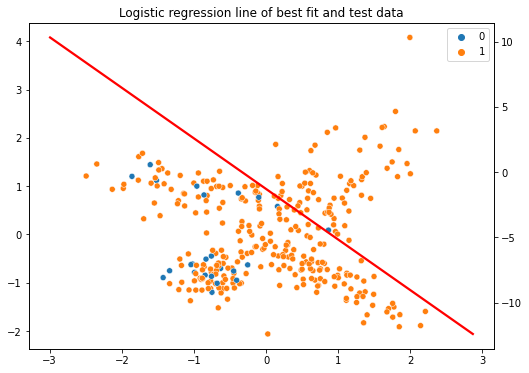

In [18]:
from sklearn.linear_model import LogisticRegression
from helpers import plot_linear_fit


penalty = 'l2'
C = 1
solver = 'lbfgs'
multi_class = 'ovr'

logistic_regression = LogisticRegression(penalty, C=C, solver=solver, multi_class=multi_class)
logistic_regression.fit(smote_train_data_scaled, smote_train_labels)


logistic_regression_label_predictions = logistic_regression.predict(smote_test_data_scaled)

test_acc_logistic = accuracy_score(labels_test, logistic_regression_label_predictions)
print(f"Test acc: {test_acc_logistic * 100}%")
plot_linear_fit(logistic_regression, smote_test_data_scaled, labels_test,
                "Logistic regression line of best fit and test data")